In [31]:
import os
# from os.path import exists
import pandas as pd
import scipy.stats as st
from scipy.stats import ttest_ind_from_stats
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import collections

## Variables

In [32]:
#Declare our variables
main_dir = '../Results'
sub_dir = '' #if we have another structure

dir = main_dir+sub_dir
outdir = f'{dir}/Data_Analysis'
files = {
    'survey_data':f'{outdir}/results_cleaned_with_central_values',
    'comments':f'{outdir}/comments/all_comments',
    'ratings':f'{outdir}/multigroup_ratings'
}

#list of conditions (used in questions' codes)
conditions = [
    'A',
    'B',
    'C'
]

#different groups of column names
demographics = [
    'Age',
    'Gender',
    'Education',
    'English_primary',
    'English_fluent',
]

scales = {
    "Understand":[
        "obvious",
        "represent",
        "understandEasi"
        ],
    "Layout":[
        "crowd",
        "distract",
        "messi"
        ],
    "DataFeat":[
        "visibl",
        "see"
        ],
    "DataRead":[
        "find",
        "identifi",
        "inform"
        ]
}

items = [
    "crowd",
    "distract",
    "find",
    "identifi",
    "inform",
    "messi",
    "obvious",
    "represent",
    "see",
    "understandEasi",
    "visibl",
]

# Load answers

In [33]:
def load_a_csv(this_file):
    this_df = pd.read_csv(this_file, converters = {'seed': str})
    if 'seed' in this_df.columns:
        this_df = this_df.set_index('seed')
    return this_df

files

{'survey_data': '../Results/Data_Analysis/results_cleaned_with_central_values',
 'comments': '../Results/Data_Analysis/comments/all_comments',
 'ratings': '../Results/Data_Analysis/multigroup_ratings'}

In [34]:
# we create a dictionary to hold dfs
data_dfs = {}
for k in files.keys():
    data_dfs.update(
        {k:load_a_csv(f'{files[k]}.csv')}
    ) 

nb_p = len(data_dfs['survey_data'])
nb_p

148

# Counting comments per stimulus / per person

In [35]:
comments_df = data_dfs['comments']
comments_info = {}

for c in conditions:
    this_c_comments = comments_df[f'{c}_comments']
    this_c_comments.dropna(inplace=True)
    this_count = len(this_c_comments)
    this_frequency = f'{this_count/nb_p*100:.2f}%'
    comments_info.update({
        f'stimulus {c}': [this_count, this_frequency]
    })

comments_info_df = pd.DataFrame.from_dict(comments_info, orient='index',
                       columns=['Comments count', 'Comment percentage'])

In [36]:
comments_info_df.to_csv(f'{files["comments"]}-counts.csv')

# Looking at raw data before modeling

In [37]:
# Compute some central values

def make_central_values(df, target_df, letter, subscale_dict):
    all_scales_dfs = []
    for scale in subscale_dict.keys():
        cols = {}
        cols.update(
            {
            f"Mean":df.mean(),
            #"Mode":df.mode(),
            "Median":df.median(),
            "Std":df.std(),
            "N":df.count()
            }
        )
        central_df = pd.DataFrame.from_dict(cols, orient='index')
        central_df.insert(0,'Subscale', scale)
        print(f'Central values of {target_df} for subscale {scale} in stimuli {letter}')
        # print(f'{central_df.T.mean()}')
        all_scales_dfs += [central_df]
    central_df = pd.concat(all_scales_dfs, axis=0)
    return central_df

# Frequencies for heatmaps
def make_frequencies(df):
    items_df_collection = {}
    for item in list(df):
        temp_df = pd.DataFrame(df[item])
        this_item_frequencies = pd.DataFrame(temp_df.groupby(by=item).value_counts()).rename_axis('likert')
        this_item_frequencies.columns = [item]
        items_df_collection.update({
            item:this_item_frequencies
        })
    all_frequencies = pd.concat(list(items_df_collection.values()), axis=1)
    all_frequencies.fillna(0, inplace=True)
    return all_frequencies

def make_frequencies_percentages(df):
    for col in df.columns:
        total = sum(df[col])
        df[col] = df[col]/total
    return df

# Utils
def get_df(all_dfs, target_df, letter, selected_cols = [], subscale_dict = {}):
    targeted_df = all_dfs[target_df]
    this_df = targeted_df[targeted_df['stimulus']==letter]
    if len(selected_cols) >0:
        this_df = this_df[selected_cols]
    if len(subscale_dict) >0:
        new_cols_order = []
        for scale in subscale_dict.keys():
            new_cols_order += subscale_dict[scale]
        this_df = this_df[new_cols_order]
    return this_df

# Look at data
def look_at_data(all_dfs, target_df, letter, selected_cols = [], subscale_dict = {}):
    df = get_df(all_dfs, target_df, letter, selected_cols)
    central_df = make_central_values(df, target_df, letter, subscale_dict)
    frequencies_df = make_frequencies(df)
    frequencies_percents_df = make_frequencies_percentages(frequencies_df)

    return central_df, frequencies_df, frequencies_percents_df

for condition in conditions:
    data_dfs.update({
        condition:{}
    })
    look_results = look_at_data(data_dfs, 'ratings', condition, selected_cols = items, subscale_dict = scales) 
    look_results[0].to_csv(f'{outdir}/ratings-central-values-{condition}.csv')
    data_dfs[condition].update({
        'central_values':look_results[0],
        'answers_frequencies':look_results[1],
        'answers_frequencies_percentages':look_results[2]
    })


Central values of ratings for subscale Understand in stimuli A
Central values of ratings for subscale Layout in stimuli A
Central values of ratings for subscale DataFeat in stimuli A
Central values of ratings for subscale DataRead in stimuli A
Central values of ratings for subscale Understand in stimuli B
Central values of ratings for subscale Layout in stimuli B
Central values of ratings for subscale DataFeat in stimuli B
Central values of ratings for subscale DataRead in stimuli B
Central values of ratings for subscale Understand in stimuli C
Central values of ratings for subscale Layout in stimuli C
Central values of ratings for subscale DataFeat in stimuli C
Central values of ratings for subscale DataRead in stimuli C


# Are repeated measure positively correlated?

For each scale, we measure if responses are positively correlated across stimuli (A-B, B-C, A-C). This is important because if the measures are positively correlated, it suggests that participants' responses are relatively consistent over time. This consistency supports the use of methods like rmcorr and mixed models that account for within-participant correlations.
But, if the correlations are negative or low, it might indicate that the repeated measures are capturing different aspects of the construct or that there is a lot of variability.

We will focus on the scales averages for this analysis. If we find weak correlations, we will analyze individual items.

In [38]:
#get the data
columns = []
for scale in scales.keys():
    for c in conditions:
        columns += [f'{c}{scale}_average']

rm_df = data_dfs['survey_data'][columns]
rm_df.rename(columns={col:col.replace('_average','') for col in columns}, inplace=True)

# Create a PDF file
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(f'{outdir}/generatedPlots/scales_correlation_checks.pdf') as pdf:
    for scale in scales.keys():
        scale_rm = rm_df[[f'{c}{scale}' for c in conditions]]
        correlation_matrix = scale_rm.corr()

        # Create a figure for the current scale with 1x3 layout
        fig, axs = plt.subplots(1, 4, figsize=(30, 8))  # Adjust figsize as needed

        # First scatterplot A-B
        sns.regplot(ax=axs[0],
                    x=scale_rm[f'{conditions[0]}{scale}'],
                    y=scale_rm[f'{conditions[1]}{scale}'])
        axs[0].set_title(f'{scale} measures correlation: {conditions[0]} vs {conditions[1]}')
        axs[0].set_xlabel(f'{conditions[0]}{scale}')
        axs[0].set_ylabel(f'{conditions[1]}{scale}')
        axs[0].set_xlim(0.8, 7.2)
        axs[0].set_ylim(0.8, 7.2)


        # Second scatterplot B-C
        sns.regplot(ax=axs[1],
                    x=scale_rm[f'{conditions[1]}{scale}'],
                    y=scale_rm[f'{conditions[2]}{scale}'])
        axs[1].set_title(f'{scale} measures correlation: {conditions[1]} vs {conditions[2]}')
        axs[1].set_xlabel(f'{conditions[1]}{scale}')
        axs[1].set_ylabel(f'{conditions[2]}{scale}')
        axs[1].set_xlim(0.8, 7.2)
        axs[1].set_ylim(0.8, 7.2)


        # Third scatterplot A-C
        sns.regplot(ax=axs[2],
                    x=scale_rm[f'{conditions[0]}{scale}'],
                    y=scale_rm[f'{conditions[2]}{scale}'])
        axs[2].set_title(f'{scale} measures correlation: {conditions[0]} vs {conditions[2]}')
        axs[2].set_xlabel(f'{conditions[0]}{scale}')
        axs[2].set_ylabel(f'{conditions[2]}{scale}')
        axs[2].set_xlim(0.8, 7.2)
        axs[2].set_ylim(0.8, 7.2)

        # Correlation matrix heatmap
        sns.heatmap(correlation_matrix,
                    annot=True,
                    cmap='RdBu',
                    vmin=-1, vmax=1, center=0,
                    square=True,
                    ax=axs[3])
        axs[3].set_title(f'{scale} measures correlations across stimuli')

        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure to pdf
        plt.close(fig)  # Close the figure to free memory





C:\Users\Anne-Flore\AppData\Local\Temp\ipykernel_30228\852606632.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rm_df.rename(columns={col:col.replace('_average','') for col in columns}, inplace=True)


In [39]:

# Look at the Layout scale items (crowd, distract, messi) because correlations are weak

Lcolumns = []
for Litem in scales['Layout']:
    for c in conditions:
        Lcolumns += [f'{c}Layout_{Litem}']

Layout_rm_df = data_dfs['survey_data'][Lcolumns]

with PdfPages(f'{outdir}/generatedPlots/Layout_items_correlation_checks.pdf') as pdf:
    for Litem in scales['Layout']:

        Litem_rm = Layout_rm_df[[f'{c}Layout_{Litem}' for c in conditions]]

        correlation_matrix = Litem_rm.corr()
        # Create a figure for the current scale with 1x3 layout
        fig, axs = plt.subplots(1, 4, figsize=(30, 8))  # Adjust figsize as needed

        # First scatterplot A-B
        sns.regplot(ax=axs[0],
                    x=Litem_rm[f'{conditions[0]}Layout_{Litem}'],
                    y=Litem_rm[f'{conditions[1]}Layout_{Litem}'])
        axs[0].set_title(f'{Litem} measures correlation: {conditions[0]} vs {conditions[1]}')
        axs[0].set_xlabel(f'{conditions[0]}Layout_{Litem}')
        axs[0].set_ylabel(f'{conditions[1]}Layout_{Litem}')
        axs[0].set_xlim(0.8, 7.2)
        axs[0].set_ylim(0.8, 7.2)

        # Second scatterplot B-C
        sns.regplot(ax=axs[1],
                    x=Litem_rm[f'{conditions[1]}Layout_{Litem}'],
                    y=Litem_rm[f'{conditions[2]}Layout_{Litem}'])
        axs[1].set_title(f'{Litem} measures correlation: {conditions[1]} vs {conditions[2]}')
        axs[1].set_xlabel(f'{conditions[1]}Layout_{Litem}')
        axs[1].set_ylabel(f'{conditions[2]}Layout_{Litem}')
        axs[1].set_xlim(0.8, 7.2)
        axs[1].set_ylim(0.8, 7.2)

        # Third scatterplot A-C
        sns.regplot(ax=axs[2],
                    x=Litem_rm[f'{conditions[0]}Layout_{Litem}'],
                    y=Litem_rm[f'{conditions[2]}Layout_{Litem}'])
        axs[2].set_title(f'{Litem} measures correlation: {conditions[0]} vs {conditions[2]}')
        axs[2].set_xlabel(f'{conditions[0]}Layout_{Litem}')
        axs[2].set_ylabel(f'{conditions[2]}Layout_{Litem}')
        axs[2].set_xlim(0.8, 7.2)
        axs[2].set_ylim(0.8, 7.2)

        # Correlation matrix heatmap
        sns.heatmap(correlation_matrix,
                    annot=True,
                    cmap='RdBu',
                    vmin=-1, vmax=1, center=0,
                    square=True,
                    ax=axs[3])
        axs[3].set_title(f'{Litem} measures correlations across stimuli')

        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure to pdf
        plt.close(fig)  # Close the figure to free memory
        



# Plotting the answers

In [40]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

In [41]:
# Create the output folder if it doesn't exist
plots_outputdir = outdir+'/generatedPlots'
if not os.path.exists(plots_outputdir):
    os.makedirs(plots_outputdir)

In [42]:
def sort_clean_col_names(df):
    init_cols = list(df)
    init_cols.sort()
    df = df[init_cols]
    clean_cols = [int(col) for col in init_cols]
    df.columns = clean_cols
    return df
    

def plot_heatmap(this_df, letter, clean_the_cols=False, col_order=[]):
    if len(col_order)>0:
        this_df = this_df[col_order]
    if clean_the_cols:
        df = sort_clean_col_names(this_df.T)
    else:
        df = this_df
    f = plt.figure(figsize=(12,12))
    plt.title(f'Answers for stimulus {letter}')
    sns.heatmap(df, vmin=0, vmax=70, annot=True, fmt=".1f", cmap="Purples", linewidths=.5, cbar=False, square=True)
    f.savefig(f"{outdir}/generatedPlots/heatmap-{letter}.pdf")

    f2 = plt.figure(figsize=(12,12))
    plt.title(f'Answers for stimulus {letter}')
    sns.heatmap(df, vmin=0, vmax=70, annot=False, cmap="Purples", linewidths=0, cbar=False, square=True)
    f2.savefig(f"{outdir}/generatedPlots/heatmap_no_label-{letter}.pdf")


def plot_data(letter, this_col_order=[]):
    plot_heatmap(data_dfs[letter]['answers_frequencies_percentages']*100, letter, clean_the_cols=True,col_order=this_col_order)

In [43]:
plotting_order=[]
for s in scales.keys():
    plotting_order += scales[s]

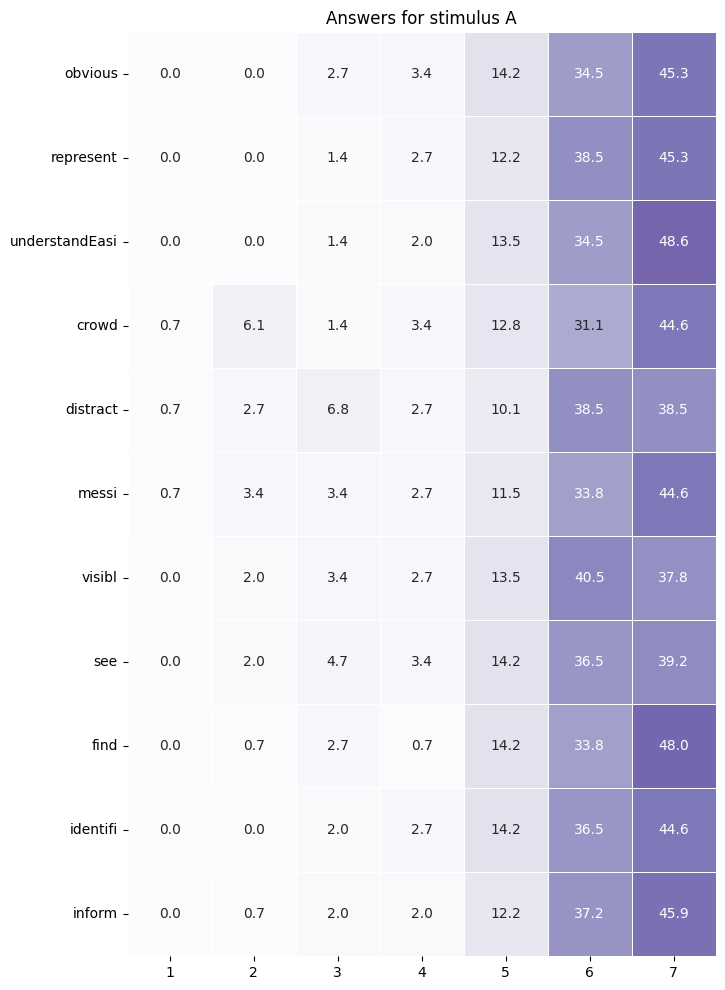

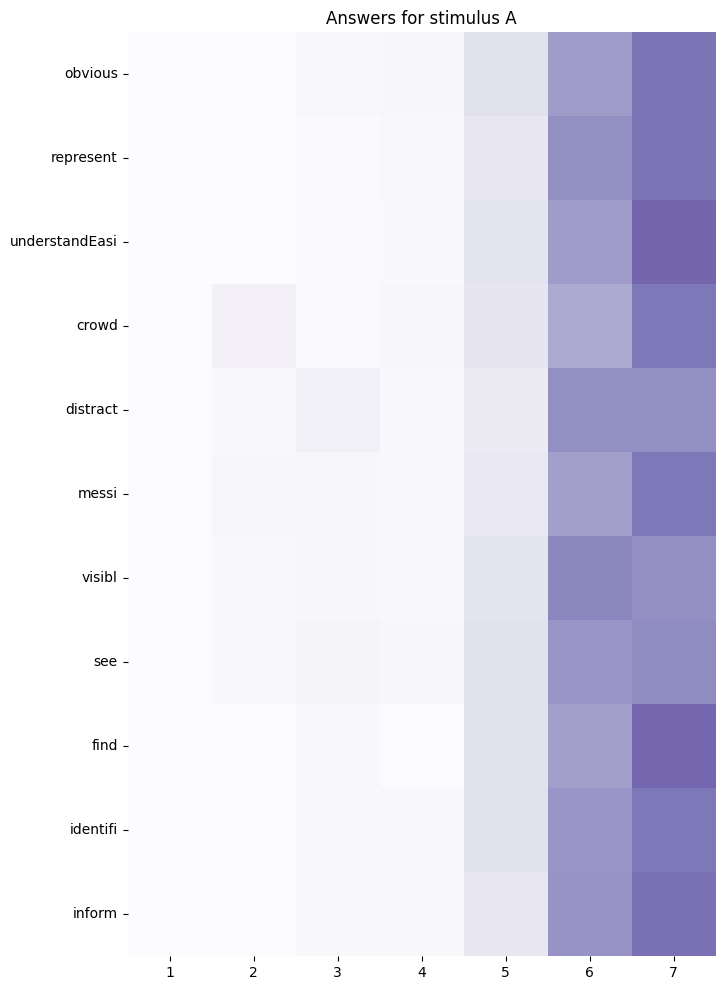

In [44]:
plot_data('A', this_col_order=plotting_order)

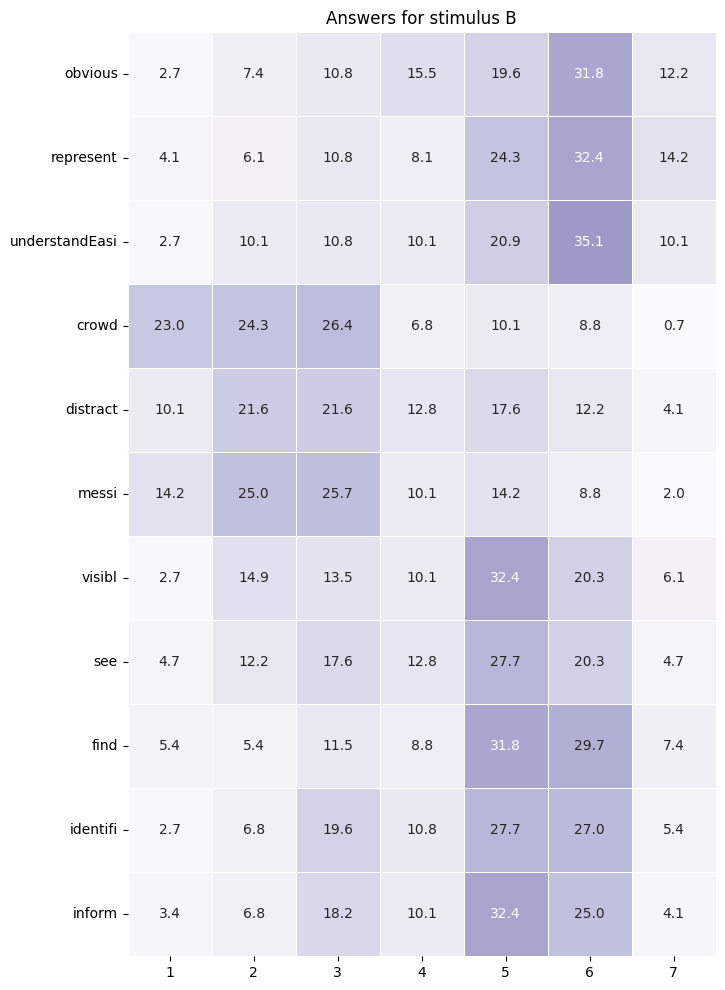

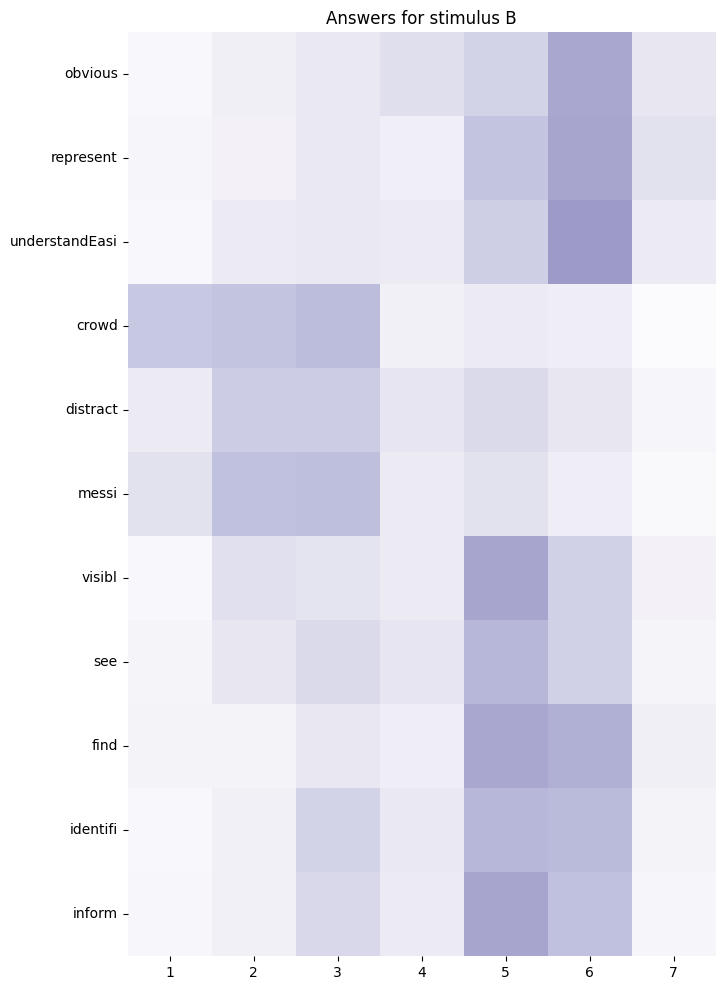

In [45]:
plot_data('B', this_col_order=plotting_order)

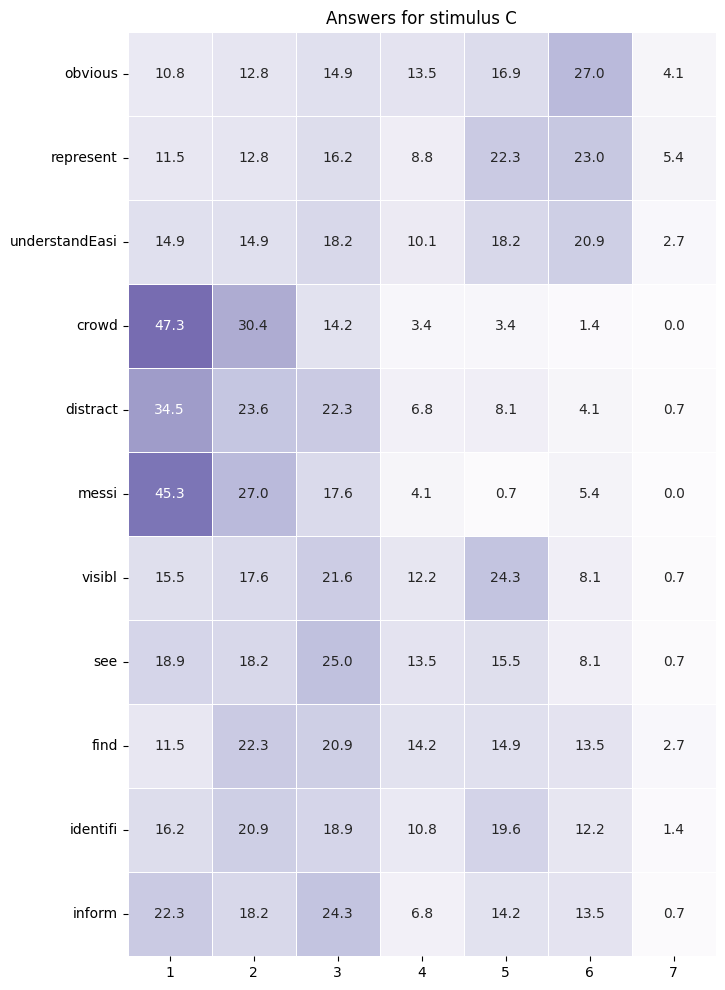

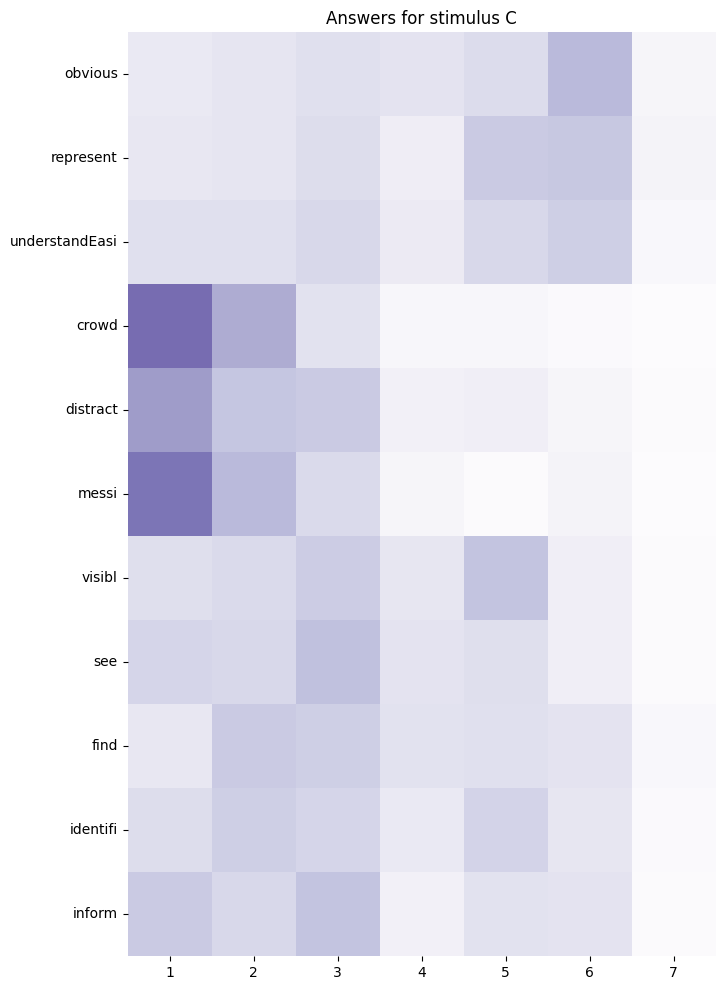

In [46]:
plot_data('C', this_col_order=plotting_order)